<a href="https://colab.research.google.com/github/JMGErie/Module-24-Final-Capstone-Project/blob/main/Steel_XGB_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
import os
import graphviz as graphviz
sns.set_theme(style="darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from google.colab import data_table
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import xgboost as xgb
import sklearn.base
from sklearn.inspection import PartialDependenceDisplay
#!pip install shap==0.23.0
#!pip install -I shap
#!pip install _fit_context

import shap




In [6]:
# loading the downloaded CSV file into a Pandas DataFrame
steel = pd.read_csv('/content/steel_strength.csv')

# Set the "formula" column as the index
steel.set_index("formula", inplace=True)

# Fill NaN values with zeroes in specific columns
columns_to_fill = ['c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']
steel[columns_to_fill] = steel[columns_to_fill].fillna(0)

#Creating a column for iron (fe)
# List of columns to subtract from 100
columns_to_subtract = ['c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']

# Create the "fe" column by subtracting values from 100
steel["fe"] = 100 - steel[columns_to_subtract].sum(axis=1)

# Initialize the StandardScaler
scaler = StandardScaler()

#seperating the features into X and target into y, y1, and y2
X = steel.drop(labels=["yield strength", "tensile strength", "elongation"], axis=1)

y = steel["yield strength"]

y_1 = steel["tensile strength"]

y_2 = steel["elongation"]

# Fit the scaler on the data and transform the features
X_scaled = scaler.fit_transform(X)

# Display the scaled DataFrame
steel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312 entries, Fe0.620C0.000953Mn0.000521Si0.00102Cr0.000110Ni0.192Mo0.0176V0.000112Nb0.0000616Co0.146Al0.00318Ti0.0185 to Fe0.860C0.0125Mn0.00274Si0.000198Cr0.00439Ni0.0786Mo0.00284V0.000765Nb0.0000600Co0.0369Al0.000619
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   c                 312 non-null    float64
 1   mn                312 non-null    float64
 2   si                312 non-null    float64
 3   cr                312 non-null    float64
 4   ni                312 non-null    float64
 5   mo                312 non-null    float64
 6   v                 312 non-null    float64
 7   n                 312 non-null    float64
 8   nb                312 non-null    float64
 9   co                312 non-null    float64
 10  w                 312 non-null    float64
 11  al                312 non-null    float64
 12  ti                312 non-null    float6

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# creating an xgboost regression model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)


# Evaluate the model
xgb_mse = mean_squared_error(y_test, xgb_predictions)
print("XGBoost Mean Squared Error:", xgb_mse)

# creating a columns for the predictions using the trained model using X_scaled and the percent error
steel['xgb_ys_preds'] = xgb_model.predict(X)
steel["xgb_ys_preds_%"] = abs(100 * (steel["xgb_ys_preds"] - steel["yield strength"]) / steel["yield strength"])

# Create a DataFrame to store predictions with absolute error less or equal to 10%
good_ys_preds_xgb = steel["xgb_ys_preds_%"] <= 10
print(good_ys_preds_xgb.value_counts())
# Count the number of "Good" predictions
good_count_xgb = good_ys_preds_xgb.value_counts()[True]

# Calculate the percentage of "Good" predictions
percentage_good_xgb = (good_count_xgb / len(steel["xgb_ys_preds_%"])) * 100

print("For XGBoost, the percentage of Yield Strength Predictions within 10% of Actual value is:", percentage_good_xgb)


XGBoost Mean Squared Error: 18539.889298940114
xgb_ys_preds_%
True     301
False     11
Name: count, dtype: int64
For XGBoost, the percentage of Yield Strength Predictions within 10% of Actual value is: 96.47435897435898


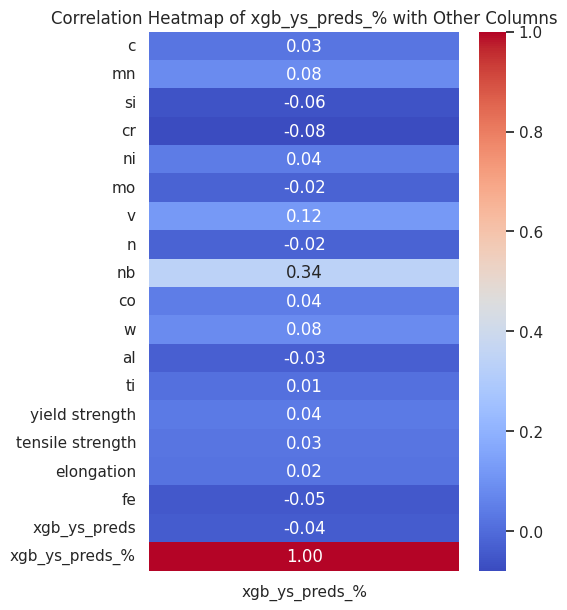

In [9]:
# Calculate the correlation matrix
xgb_corr = steel.corr()

# Plot the heatmap
plt.figure(figsize=(5, 7))
sns.heatmap(xgb_corr[['xgb_ys_preds_%']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of xgb_ys_preds_% with Other Columns')
plt.show()

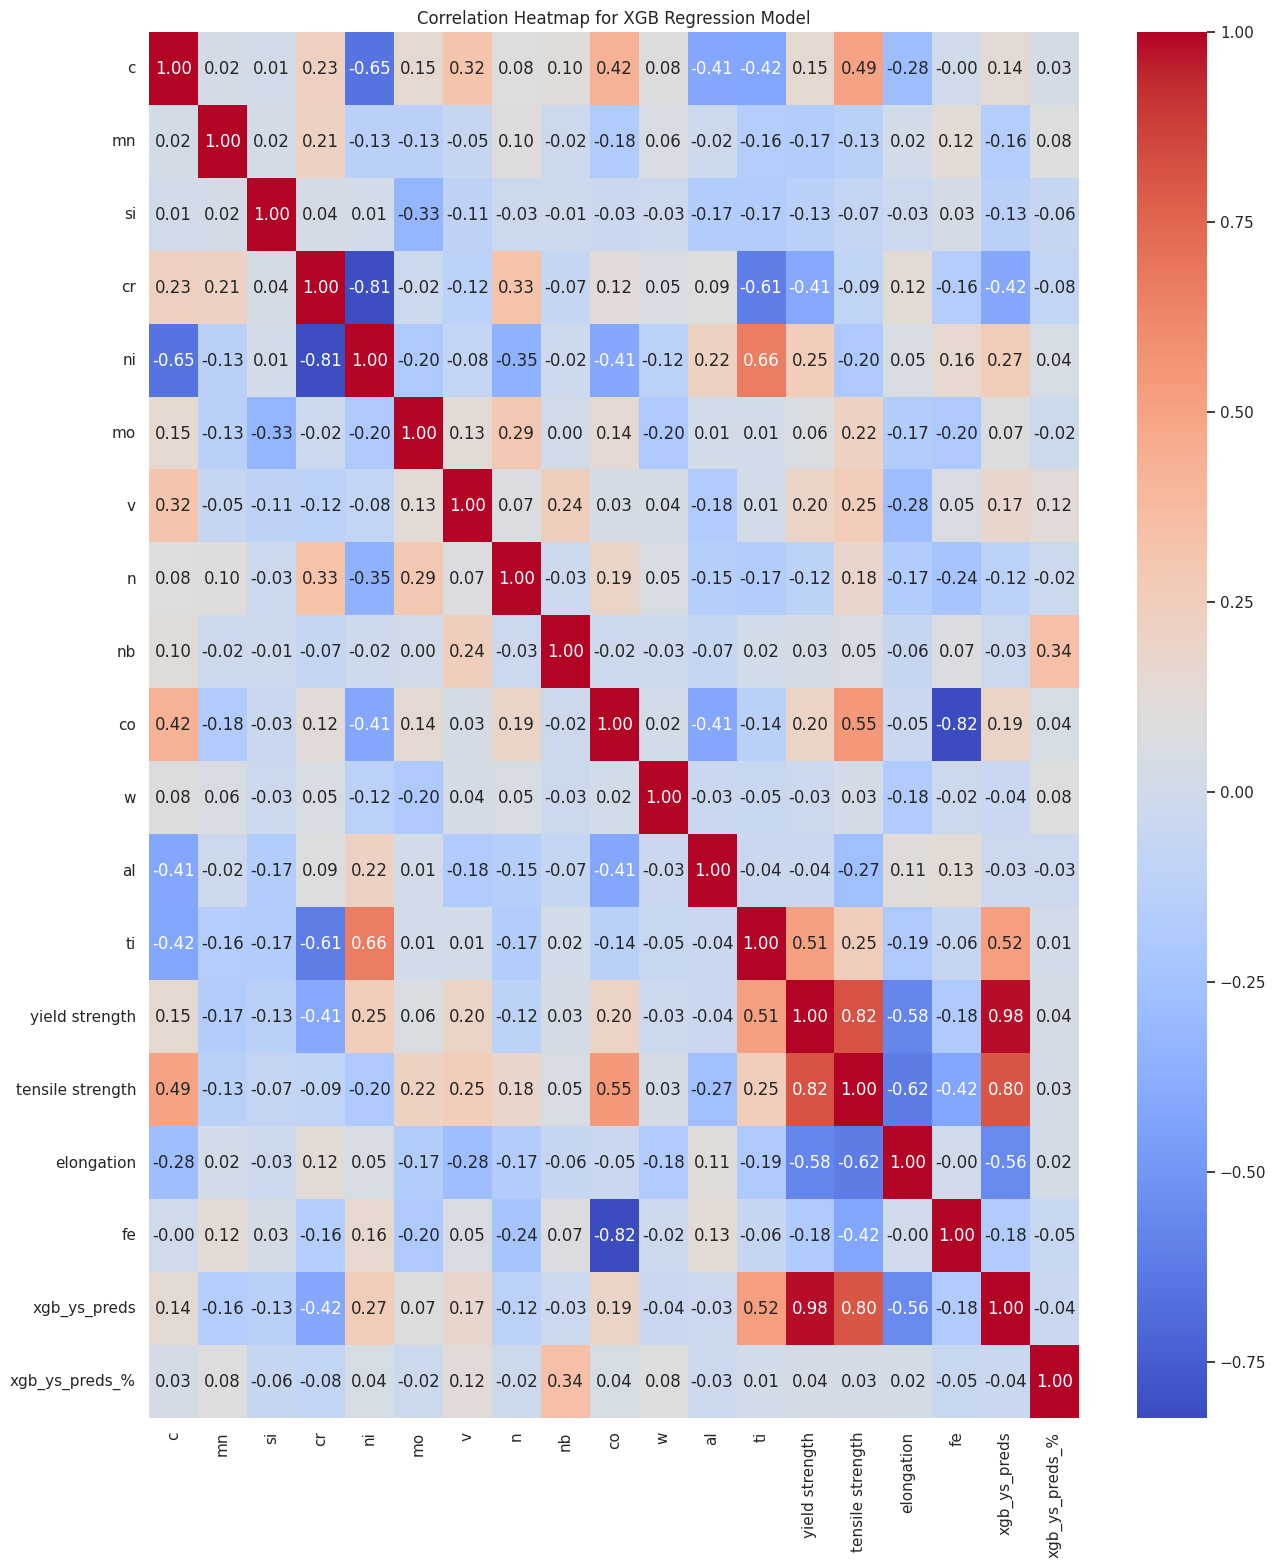

In [10]:
# Plot the heatmap for the entire correlation matrix
plt.figure(figsize=(15, 18))
sns.heatmap(xgb_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for XGB Regression Model')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


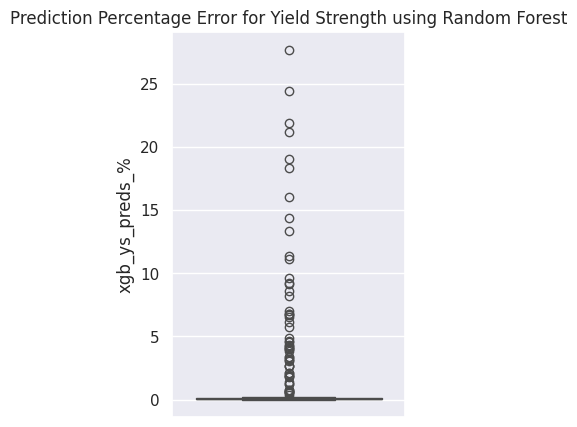

In [11]:
# Create box plot
plt.figure(figsize=(3, 5))
sns.boxplot(y=steel["xgb_ys_preds_%"])
plt.title('Prediction Percentage Error for Yield Strength using Random Forest')
plt.show()

In [12]:
# Getting the feature importances from XGBoost Model
feature_importances = xgb_model.feature_importances_

# Print feature importances
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance:.3f}")

c: 0.053
mn: 0.149
si: 0.048
cr: 0.020
ni: 0.028
mo: 0.036
v: 0.021
n: 0.007
nb: 0.035
co: 0.032
w: 0.023
al: 0.054
ti: 0.469
fe: 0.026


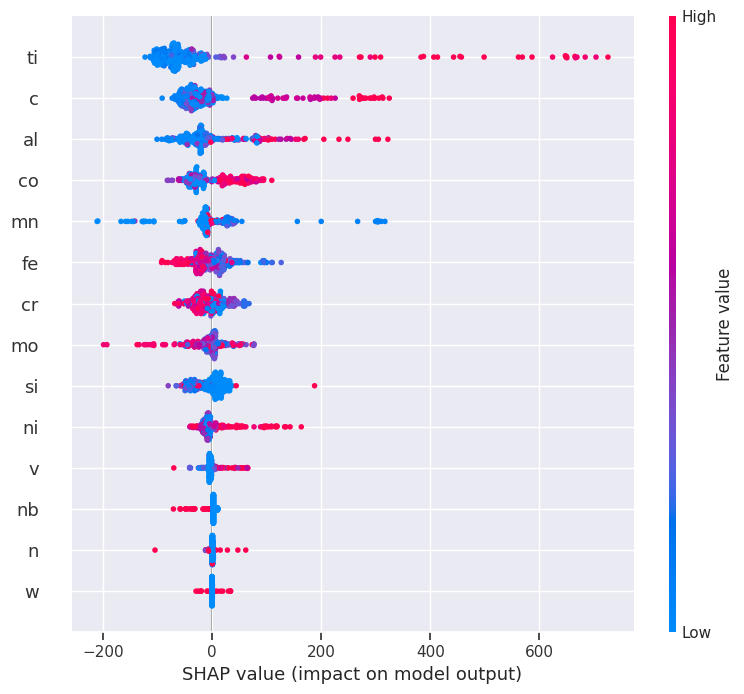

In [13]:
# Creating a SHAP
# Create a SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X)

# Visualize SHAP values
shap.summary_plot(shap_values, X)

In [ ]:
#Tensile Strngth Modeling

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_1_train, y_1_test = train_test_split(X, y_1, test_size=0.2, random_state=42)

# creating an xgboost regression model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_1_train)
xgb_ts_preds = xgb_model.predict(X_test)


# Evaluate the model
xgb_mse = mean_squared_error(y_1_test, xgb_ts_preds)
print("XGBoost Mean Squared Error:", xgb_mse)

# creating a columns for the predictions using the trained model using X_scaled and the percent error
steel['xgb_ts_preds'] = xgb_model.predict(X)
steel["xgb_ts_preds_%"] = abs(100 * (steel["xgb_ts_preds"] - steel["tensile strength"]) / steel["tensile strength"])

# Create a DataFrame to store predictions with absolute error less or equal to 10%
good_ts_preds_xgb = steel["xgb_ts_preds_%"] <= 10
print(good_ts_preds_xgb.value_counts())
# Count the number of "Good" predictions
good_count_xgb = good_ts_preds_xgb.value_counts()[True]

# Calculate the percentage of "Good" predictions
percentage_good_xgb = (good_count_xgb / len(steel["xgb_ts_preds_%"])) * 100

print("For XGBoost, the percentage of Tensile Strength Predictions within 10% of Actual value is:", percentage_good_xgb)


XGBoost Mean Squared Error: 14887.34276202879
True     304
False      8
Name: xgb_ts_preds_%, dtype: int64
For XGBoost, the percentage of Tensile Strength Predictions within 10% of Actual value is: 97.43589743589743


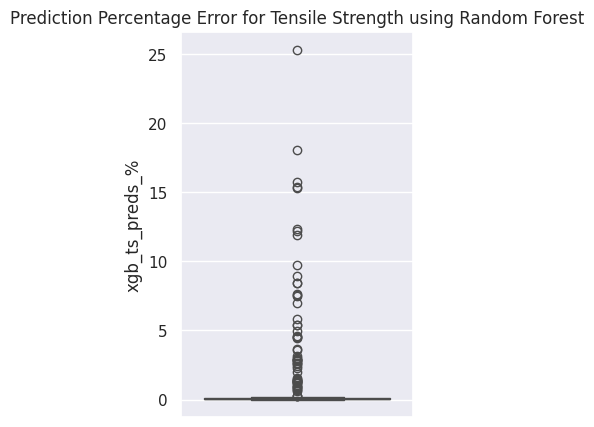

In [ ]:
# Create box plot
plt.figure(figsize=(3, 5))
sns.boxplot(y=steel["xgb_ts_preds_%"])
plt.title('Prediction Percentage Error for Tensile Strength using Random Forest')
plt.show()

In [ ]:
pip install streamlit xgboost pandas
import joblib

# Save the model
joblib.dump(xgb_model, 'xgb_model.pkl')

import joblib

# Save the model
joblib.dump(xgb_model, 'xgb_model.pkl')
